# **Binary Classifier Construction**
This notebook trains a network to distinguish between the two most common key signatures of Irish trad music - Dmaj and Gmaj

In [ ]:
import pandas as pd
import numpy as np, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

df = pd.read_csv(r"/content/drive/MyDrive/project/data.csv")
key = ['Dmaj', 'Gmaj']
filtered = df[df.Key.isin(key)]

- Reads the labelled data from the .csv and filters so that we're only analysing tunes that are in Dmaj or Gmaj (i.e. excluding tunes in the less frequent keys of Amaj or Emin etc.)

In [ ]:
 l = filtered['Key']
i =0
y =  np.empty(len(l), dtype = float)
for t in l:
  if t == 'Dmaj':
    y[i] = 0
  elif t =="Gmaj":
    y[i] = 1
  i= i+1


- 'y' (the output data) is the key of a tune i.e. Dmaj or Gmaj

In [ ]:
batch = len(y)
train =round(batch*0.7)
test = batch -train


The length of the entire list of tunes that fit our key criterium is the 'batch'
The data is then split 70:30 train/test

In [ ]:
source = "/content/drive/MyDrive/project/music/fionn session/"  + filtered['Track']
n = len(source)
x = np.empty((batch, 12, 3876), dtype = float)
hop_length = 256
i = 0;
for f in source:
    a, sr = librosa.load(f, duration = 45)
    ch = librosa.feature.chroma_stft(a, sr=sr, hop_length=hop_length)
    x[i] = ch
    i= i+1
    print(i, "/", batch)

'x' (the input data) is the chromagram transform of the first 45 secs of the audiofiles
  - the 45 seconds is to normalise the length of the audio file/ the length of the chromagram vector so that the network accepts it
  - the shortest tune in the Fionn Sessiun data set is 48 seconds, so it was decided that 45 would suit
  - the chromagram was chosen as the best way to process the data for this work as it represents audio as mappings to the 12 main notes of the western scale (i.e. C, C#, D, E♭ etc.) and thus would be the best way to determine key, as the key informs which of these notes would appear (and generally the frequency at which they appear)
      - The size of the computed chromagram is 12 x 3876, where the 12 refers to the 12 notes of the Western Scale and the 3876 is the product of the duration (45 s) and the sample rate (22050 Hz) , divided by the hop size (256) -> 3875.977 ~= 3876

In [ ]:
x_train = x[0:train]
x_test = x[train:batch]
y_train = y[0:train]
y_test = y[train:batch]

Splits the computed chromagram arrays into the test/train data

- the training and test data has to be reshaped in order for it to accuarately match the shape of the CNN
- since the 2DCov layers have a third dimension (reserved for RGB values) so in order to compile out model our data needs to have a colour dimension
  - the chromagram data isnt stored as three separate channels of RGB, but just a single pixel value between 0 and 1
  - therefore we have to include the third dimension, but only set it to 1
- our 2D array of chroma vectors must be reshaped to account for this

In [ ]:
rx_train = x_train.reshape((train,12,3876,1))
ry_train = y_train.reshape((train,1))

rx_test = x_test.reshape((test,12,3876,1))
ry_test = y_test.reshape((test,1))


In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
inputs = x_train.reshape((train,12,3876,1))
targets = y_train.reshape((train,1))
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(12, 3876,1), data_format='channels_last', padding="same"))
  model.add(layers.MaxPooling2D((2, 2)))
  #added dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #added dropout
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))

  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  history = model.fit(inputs[train], targets[train], 
                    epochs=10, validation_data = (rx_test,ry_test))
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  predicted_categories = model.predict_classes(inputs[test])
  true_categories = tf.concat(targets[test], axis=0)
  array = confusion_matrix(predicted_categories, true_categories, normalize='true')
  df_cm = pd.DataFrame(array, index = [i for i in ['Dmaj', 'Gmaj']],
                    columns = [i for i in ['Dmaj', 'Gmaj']])
  plt.figure(figsize = (10,7))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  sn.heatmap(df_cm, annot=True)
  fname = '/content/drive/MyDrive/project/bin class models/key_model'+str(fold_no)
  model.save(fname)
  # Increase fold number
  fold_no = fold_no + 1

Uses K-Fold Cross Validation to split the training data into 5 folds, wherein 80% of the training data is used to train with the remianing 20% used to validate.


Creates a CNN with:
- Three 2DConv layers (the first with 32 nodes, the other two with 64)
- Two Max Pooling layers between the convolutional layers
- Two Dense layers at the end 
  - one with 64 fully connected nodes
  - a final binary node with a sigmoid activation function due to the binary nature of this classification

- Model is compiled with the 'adam' optimiser (i.e. using the Adam algorithm which is a *"stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments"*
- Loss is computed as binary cross entropy since we're creating a binary classifier
- the metric to be tracked for success is marked as accuracy

- run the model for 10 epochs

Plots the confusion matrices for each fold and saves the model so that the best can be reused in the final training and testing on the whole data set

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/project/bin class models/key_model2')

* Load in best performing model from the folds (it was k = 2)

In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []
 
  def on_epoch_end(self, epoch, logs={}):
    validation_data = (rx_test,ry_test)
    val_predict = (np.asarray(self.model.predict(validation_data[0]))).round()
    val_targ = validation_data[1]
    _val_f1 = f1_score(val_targ, val_predict)
    _val_recall = recall_score(val_targ, val_predict)
    _val_precision = precision_score(val_targ, val_predict)
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
    return
 
metrics = Metrics() 

* Create metrics that will record the precision recall and F Measure each epoch

In [ ]:
history = model.fit(x = rx_train, y=ry_train,
                    epochs=10, validation_data = (rx_test,ry_test), callbacks=[metrics])

Epoch 1/10
7/7 [==============================] - 32s 140ms/step - loss: 0.2298 - accuracy: 0.9227 - val_loss: 0.1900 - val_accuracy: 0.9518
— val_f1: 0.951220 — val_precision: 0.928571 — val_recall 0.975000
Epoch 2/10
7/7 [==============================] - 0s 64ms/step - loss: 0.1022 - accuracy: 0.9588 - val_loss: 0.2013 - val_accuracy: 0.9518
— val_f1: 0.951220 — val_precision: 0.928571 — val_recall 0.975000
Epoch 3/10
7/7 [==============================] - 0s 64ms/step - loss: 0.0710 - accuracy: 0.9691 - val_loss: 0.2522 - val_accuracy: 0.9518
— val_f1: 0.951220 — val_precision: 0.928571 — val_recall 0.975000
Epoch 4/10
7/7 [==============================] - 0s 65ms/step - loss: 0.0325 - accuracy: 0.9845 - val_loss: 0.2913 - val_accuracy: 0.9518
— val_f1: 0.951220 — val_precision: 0.928571 — val_recall 0.975000
Epoch 5/10
7/7 [==============================] - 0s 65ms/step - loss: 0.0109 - accuracy: 0.9948 - val_loss: 0.3446 - val_accuracy: 0.9518
— val_f1: 0.951220 — val_precision:

* Train the model for 10 epochs with the metrics as callbacks

Score for model: loss of 0.41242557764053345; accuracy of 95.18072009086609%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


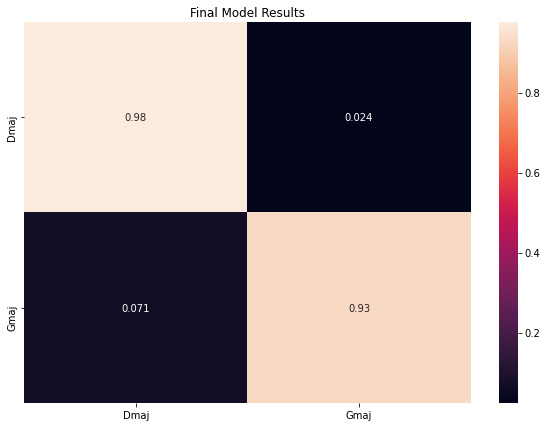

In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

scores = model.evaluate(rx_test, ry_test, verbose=0)
print(f'Score for model: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

predicted_categories = model.predict_classes(rx_test)
true_categories = tf.concat(ry_test, axis=0)
array = confusion_matrix(predicted_categories, true_categories, normalize='true')
df_cm = pd.DataFrame(array, index = [i for i in ['Dmaj', 'Gmaj']],
                  columns = [i for i in ['Dmaj', 'Gmaj']])
plt.figure(figsize = (10,7))
plt.title('Final Model Results')
plt.xlabel('Predicted')
plt.ylabel('True')
sn.heatmap(df_cm, annot=True)

* Plot the confusion matrix of the model

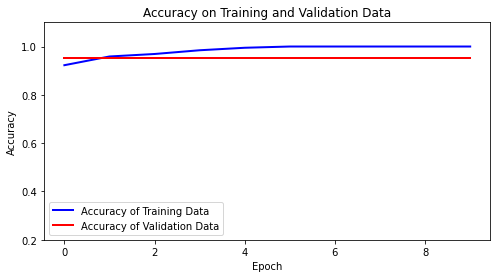

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(history.history['accuracy'], label='Accuracy of Training Data', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label = 'Accuracy of Validation Data',color='red', linewidth=2)
plt.title('Accuracy on Training and Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.1])
plt.legend()

- plot graph of accuracy against validation accuracy per epoch

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(history.history['loss'], label='Loss of Training Data', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label = 'Loss of Validation Data',color='red', linewidth=2)
plt.title('Loss on Training and Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.2])
plt.legend()



*   Plot validation loss and training loss per epoch



In [ ]:

plt.rcParams["figure.figsize"] = (8,4)
plt.plot(metrics.val_f1s, label = 'F1 Scores',color='blue', linewidth=2)
plt.plot(metrics.val_precisions, label = 'Precision Scores',color='green', linewidth=2)
plt.plot(metrics.val_recalls, label = 'Recall Scores',color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precision, Recall and F1 Score for Final Binary Key Model')
plt.ylim([0.2, 1.2])
plt.legend()
test_loss, test_acc = model.evaluate(rx_test,  ry_test, verbose=2)

*  Plot F1 Score precision and recall of validation data per epoch

In [ ]:
from keras.utils.vis_utils import plot_model
from PIL import Image
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

* Show the layout of the model used

In [ ]:
model.save('/content/drive/MyDrive/project/key_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/project/key_model/assets


* Save the final model